In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["patch.force_edgecolor"]=True
import csv
from demyst.analytics import Analytics                 #importing my most used libraries

In [2]:
df1= pd.read_csv('input.csv')# read csv, show first 2 records
df1.head(2)

,street,state,city,postcode,safety_flag
0,3160 Otto Dr,FL,Lakeland,33812-5237,False
1,940 Tulip Dr,IN,Indianapolis,46227,False


In [3]:
df1.describe() #get an overview of statistics of our input data
               # 59 unique states seems a little weird. UPDATE: some state values have spaces thats why showing more

,street,state,city,postcode,safety_flag
count,11229,11220,11220,11220,11229
unique,11198,59,4181,9127,2
top,190 E 98th St,CA,New York,94107,False
freq,4,1251,245,25,10119


In [4]:
df1.info() #to check the data types of the columns
           # data has 9 nulls in State,City,Postcode
           
           # safety flag will need to be converted to 0 for false, 1 for true

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 5 columns):
street         11229 non-null object
state          11220 non-null object
city           11220 non-null object
postcode       11220 non-null object
safety_flag    11229 non-null bool
dtypes: bool(1), object(4)
memory usage: 362.0+ KB


False    10119
True      1110
Name: safety_flag, dtype: int64

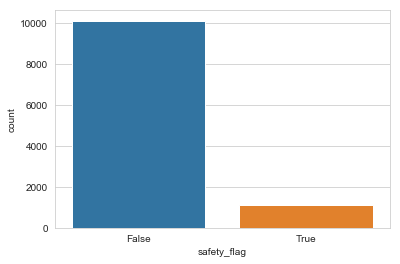

In [5]:
sns.countplot(x=df1.safety_flag) #target variable seems pretty unbalanced towards FALSE. Will check again after enrichment
                                 # imbalanced target variable can create a bias in our model

df1['safety_flag'].value_counts()

In [6]:
df1['safety_flag'].value_counts() #10 to 1 ratio is not good for modelling

False    10119
True      1110
Name: safety_flag, dtype: int64

In [7]:
df1['city'] = df1['city'].str.upper() #duplicate cities were appearing because some had the first letter as upper.
df1.safety_flag=df1.safety_flag.astype(int) #target variable to numerical(0,1) for binary classification

In [8]:
df1['city'].nunique() # DOWN FROM 4181 unique values 

3785

In [11]:
df1.rename(columns = {'postcode':'post_code'}, inplace = True)

In [9]:
analytics_up= Analytics(key="e561f52a11c1df40c41a34361ff4c6af")

In [12]:
analytics_up.validate(df1)

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.8% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
post_code,Some Invalid,0.1% of the values of this column failed validation. One example of an invalid value is 'nan'. Click here for documentation for this column.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


In [14]:
df1[df1['post_code'].isnull()] #i dont see the point in filling these as the time taken to automate these would
                               # not really benefit us in the model phase because its only 9 records so I choose to remove these

,street,state,city,post_code,safety_flag
9347,,NaN,NaN,NaN,0
9388,499 Beckett Road Suite 201B,NaN,NaN,NaN,1
9694,,NaN,NaN,NaN,0
9860,"5805 Sepulveda Blvd, Ste 670",CA,VAN NUYS,NaN,1
10528,PO Box 390183 211 Hope Street,NaN,NaN,NaN,1
10531,,NaN,NaN,NaN,0
10634,200 Vesey St Suite 24081,NaN,NaN,NaN,0
11129,"147 Prince Street Brooklyn, NY 11201",NaN,NaN,NaN,0
11219,"3333 Michelson Dr Suite 300 Irvine, CA 92612",NaN,NaN,NaN,0


In [15]:
df1.dropna(inplace=True)
analytics_up.validate(df1) # still 16.7% of state values are failing. needs further investigation

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.7% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
safety_flag,Unrecognized Column Name,This column name is not supported. Click here for a list of all supported column names.


In [17]:
df1.rename(columns = {'safety_flag':'number'}, inplace = True)

analytics_up.validate(df1) # still failing as column should be str type

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.7% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
number,Not a String Column,You must convert this column to string type.


In [18]:
df1['number'] = df1['number'].astype(str)
analytics_up.validate(df1) # finally works, now only state column is left 16.7% vakue still failing

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,Some Invalid,16.7% of the values of this column failed validation. One example of an invalid value is 'NJ '. Click here for documentation for this column.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
number,All Valid,All values in this column are good to go.


In [21]:
#above you can see that NJ appears to have a space char infront of it 'NJ '<-- this needs to be removed and then we can try again
df1['state']= df1['state'].str.replace(' ','')
analytics_up.validate(df1)

Column,Status,Description
street,All Valid,All values in this column are good to go.
state,All Valid,All values in this column are good to go.
city,All Valid,All values in this column are good to go.
post_code,All Valid,All values in this column are good to go.
number,All Valid,All values in this column are good to go.


In [27]:
# Turns out that was the issue! Now we can go ahead and search demyst platform

analytics_up.search(df1)

,country,street,post_code,city,state
Option 1,☐,☒,☒,☒,☒


In [49]:
job_id= analytics_up.enrich(["attom_expanded_profile_report"],df1)
analytics_up.enrich_download_to_disk(job_id, "output.csv")

Verifying providers...
Starting enrichment...


attom_expanded_profile_report: Inputs are missing a field that is necessary to run this data provider
* state: The type "Country" was not given in the input, but expected. Passed types: Number, City, State, PostCode, Street
* post_code: The type "Country" was not given in the input, but expected. Passed types: Number, City, State, PostCode, Street
Validation failed


In [50]:
# Therefore, I will add a new column which will have all entries as US
df1['country']='US'

In [53]:
job_id2= analytics_up.enrich(["attom_expanded_profile_report"],df1[10:15])        #new job id for new df1 with column country
analytics_up.enrich_download_to_disk(job_id2, "output.csv")   # using dowload to disk in order to cache it in local memory as instructed                

Verifying providers...
Starting enrichment...
Enrich Job ID: 9881


IntProgress(value=1, max=2)

HTML(value='Checking status...')

In [ ]:
# the enrichment process was successful for the 5 records I had sent(10:15)
# enrichment process had failed earlier when I had passed the entire df1 

In [54]:
df3= pd.read_csv('output.csv')

In [57]:
df3.head()

,inputs.city,inputs.country,inputs.number,inputs.post_code,inputs.state,inputs.street,attom_expanded_profile_report.row_id,attom_expanded_profile_report.client_id,attom_expanded_profile_report.attom_id,attom_expanded_profile_report.error
0,FAIRFIELD,US,0,94533-6834,CA,2385 Burgundy Way,0,NaN,156023420,NaN
1,DULUTH,US,0,55811-9729,MN,5956 Sunny Ln,1,NaN,141071148,NaN
2,REGO PARK,US,0,11374-2213,NY,9725 64th Ave,2,NaN,169759254,NaN
3,LACONIA,US,0,03246-2701,NH,16 Belknap St,3,NaN,155173818,NaN
4,MIAMI,US,0,33143-7790,FL,8215 SW 72nd Ave,4,NaN,26311336,NaN


In [58]:
# as of right now I have only 2 numerical columns with my enriched data attom_id, and post_code... 
# I am going try to get the infutor data enricher whcih  might have more numerical columns which will only benefit my model.
df4= df1[['city','post_code','state','street']] # only get the columns infutor wants
job_id3= analytics_up.enrich(["infutor_property_append"],df4[10:15])        #new job id for new df1 with column country
analytics_up.enrich_download_to_disk(job_id3, "output1.csv") 

Verifying providers...


Sorry, either you mistyped the product name infutor_property_append or your organization doesn't have access to that product.


In [ ]:
# Turns out the Search method for the library was right as it only showed me the atoms enrichment.
# I dont have access to anything but atom so I am going to have to make do with what I got.

In [62]:
job_id4= analytics_up.enrich(["attom_expanded_profile_report"],df1[:1000])     
analytics_up.enrich_download_to_disk(job_id4, "output2.csv")         

Verifying providers...
Starting enrichment...
Enrich Job ID: 9888


IntProgress(value=1, max=2)

HTML(value='Checking status...')

In [65]:
# ENRICHMENT failed for df1[:11220]- saying I have insufficient credits to do so.
# 1000 appears to work. I will try 5000,if it does not work, ill stick to 1000.
job_id5= analytics_up.enrich(["attom_expanded_profile_report"],df1[:5000])     
analytics_up.enrich_download_to_disk(job_id5, "output3.csv")         


Verifying providers...
Starting enrichment...
Enrich Job ID: 9890


IntProgress(value=1, max=2)

HTML(value='Checking status...')

In [ ]:
# 5000 appears to have worked. I am going to take my chances and build my model off these records.
# as this even took 10minutes to enrich..

In [19]:
df5= pd.read_csv("output3.csv")


In [20]:
df5.columns # our enriched columns

Index(['inputs.city', 'inputs.country', 'inputs.number', 'inputs.post_code',
       'inputs.state', 'inputs.street', 'attom_expanded_profile_report.row_id',
       'attom_expanded_profile_report.client_id',
       'attom_expanded_profile_report.attom_id',
       'attom_expanded_profile_report.error'],
      dtype='object')

In [21]:
df5.info()   #our atom_id that we will use for our model has 895 missing records.. 
             # either I can use only those 4105 records or I could just use all 5000 and see how it goes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
inputs.city                                5000 non-null object
inputs.country                             5000 non-null object
inputs.number                              5000 non-null int64
inputs.post_code                           5000 non-null object
inputs.state                               5000 non-null object
inputs.street                              5000 non-null object
attom_expanded_profile_report.row_id       5000 non-null int64
attom_expanded_profile_report.client_id    0 non-null float64
attom_expanded_profile_report.attom_id     4105 non-null float64
attom_expanded_profile_report.error        0 non-null float64
dtypes: float64(3), int64(2), object(5)
memory usage: 390.7+ KB


In [22]:
df5=df5[['inputs.number', 'inputs.post_code',
       'inputs.state','attom_expanded_profile_report.attom_id' ]] 

# These are the only columns that can be manipulated and pushed into the model
# city,street have too many categories(uniques) and few observations for each therefore they will not work for our model
# I will atmept to crate dummies for STATE.. will make us have more than 50 columns . but its worth a try to add state
# Postal code will need to be numeric for the model to understand. I will remove '-' with '.' and convert the column to float
# Will have to fill missing values in attom_id to 0 if I intend to use all 5000 records

In [23]:
df5['attom_expanded_profile_report.attom_id'].fillna(value=0,inplace=True) # fill missing values with 0

In [24]:
df5['inputs.post_code']= df5['inputs.post_code'].str.replace('-','.')

# please ignore the error below.. I had ran the code earlier n forgot I ran it.. 

In [25]:
df5['inputs.post_code']=df5['inputs.post_code'].astype(float) #--> to convert 11232-2323 into 11232-2323 in float
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
inputs.number                             5000 non-null int64
inputs.post_code                          5000 non-null float64
inputs.state                              5000 non-null object
attom_expanded_profile_report.attom_id    5000 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 156.3+ KB


In [26]:
# as we can see above all our columns are ready to go in the model except state
# before I create dummies for state column I would like to see how balanced the target variable is now
df5['inputs.number'].value_counts()

0    4805
1     195
Name: inputs.number, dtype: int64

In [27]:
# THIS IS A BIG problem
# ratio right now is 24:1 .. up from before enrichment when it was something like 10:1
# i need to find a way to oversample the True values without creating new data(more tedious process)

In [28]:
dftrue=df1[df1['number']=='1'] #1106 rows of True.. 5000-1106=3894
                               # Note: I am using df1 which has all schema validated and updated.. 

NameError: name 'df1' is not defined

In [95]:
dffalse=df1[df1['number']=='0'][:3894] #<--- using only 3894 rows...total 5000

In [96]:
dfbalanced= pd.concat([dftrue,dffalse],ignore_index=True)


In [98]:
dfbalanced['number'].value_counts() #much better 

0    3894
1    1106
Name: number, dtype: int64

In [99]:
# That is a significant improvement from 24:1.. now it is 3.5:1
# Unfortunately we have to enrich dfbalanced again ...
# This should be the last time we have to enrich data...

In [117]:
job_id6= analytics_up.enrich(["attom_expanded_profile_report"],dfbalanced[:5000])     
analytics_up.enrich_download_to_disk(job_id6, "output4.csv")         


Verifying providers...
Starting enrichment...


Aborting due to insufficient credits.


In [ ]:
# I have asked Harshit for more credits as balancing my target variable will be crucial for the performance of my model
# For now I am going to continue to see how the model performs without the balanced target variable.
# SOLUTION UPDATE: Instead of manually creating the oversampling i used sci kit learn to randomnly oversample my already enriched df5

In [29]:
df6=df5 #--> wanted to preserve df5

In [30]:
df7=pd.get_dummies(df6,columns=['inputs.state'],drop_first=True) #created dummy variables for each state

In [31]:
df7.columns #our new columns thanks to dummy variables(for each state, dropping first)

Index(['inputs.number', 'inputs.post_code',
       'attom_expanded_profile_report.attom_id', 'inputs.state_AL',
       'inputs.state_AR', 'inputs.state_AZ', 'inputs.state_CA',
       'inputs.state_CO', 'inputs.state_CT', 'inputs.state_DC',
       'inputs.state_DE', 'inputs.state_FL', 'inputs.state_GA',
       'inputs.state_HI', 'inputs.state_IA', 'inputs.state_ID',
       'inputs.state_IL', 'inputs.state_IN', 'inputs.state_KS',
       'inputs.state_KY', 'inputs.state_LA', 'inputs.state_MA',
       'inputs.state_MD', 'inputs.state_ME', 'inputs.state_MI',
       'inputs.state_MN', 'inputs.state_MO', 'inputs.state_MS',
       'inputs.state_MT', 'inputs.state_NC', 'inputs.state_ND',
       'inputs.state_NE', 'inputs.state_NH', 'inputs.state_NJ',
       'inputs.state_NM', 'inputs.state_NV', 'inputs.state_NY',
       'inputs.state_OH', 'inputs.state_OK', 'inputs.state_OR',
       'inputs.state_PA', 'inputs.state_RI', 'inputs.state_SC',
       'inputs.state_SD', 'inputs.state_TN', 'inputs.sta

In [32]:
df8=df7[df7['inputs.number']==1]

In [34]:
X= df8.drop(columns=['inputs.number'],axis=1)  #initiating our attributes and target
y= df8['inputs.number']
                              

In [35]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [52]:
X= df7.drop(columns=['inputs.number'],axis=1)  #initiating our attributes and target
y= df7['inputs.number']
                               #creating my attributes 

In [37]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [16]:
from sklearn.model_selection import GridSearchCV
def best_machine(model, parameters, X, y):                         # not final model.. just doing grid search on 
                                                                   # multiple algorithms to get the best score
                                                                   # after which I will make the one I choose retrainable
    grid =  GridSearchCV(model, parameters, error_score=0.)        # Just a method to automate the process of 
                                                                   # seeing what is our baseline accuracy 
    grid.fit(X,y)
    print(grid.best_score_)
    print(grid.best_params_)
    print(round(grid.cv_results_['mean_fit_time'].mean(),3))
    print(round(grid.cv_results_['mean_score_time'].mean(),3))
    


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier     #importing the classifiers

In [18]:
lr_parameters= {'C':[0.01,1,10,100],'penalty':['l1','l2']}
knn_parameters= {'n_neighbors':[1,3,5,7,9]}
forest_parameters= {'n_estimators':[10,50,100],'max_depth':[None,1,3,5,7]} #trial parameters to see what would work best

In [41]:
lr=LogisticRegression()
knn=KNeighborsClassifier()     
forest=RandomForestClassifier()         #initiating the classifiers

In [20]:
best_machine(knn, knn_parameters, X, y)   #not performing at all with imbalanced data

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.961
{'n_neighbors': 5}
0.009
0.061


In [21]:
best_machine(forest, forest_parameters, X, y)   #not performing at all with imbalanced data 

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.961
{'max_depth': 1, 'n_estimators': 10}
0.176
0.015


In [22]:
# All models will give 0.961 accuracy as the data is 195/4805 = 0.04... 1-0.04= .96
# Therefore my models are not performing at all.. they are just reeading the data because of highly imbalanced target variable.
# Need to figure out a way to oversample True without having to enrich it again as I am out of credits.

In [547]:
from sklearn.datasets import make_classification
X_train, y_train = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                            n_clusters_per_class=2,
                           flip_y=0.20,
                            weights=[0.04,0.96],
                           class_sep=0.8, random_state=0)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)


# There are more methods to oversample my data like SMOTE which generates new samples in by interpolation
# However, I feel like for our case a random sampler will do the job by creating more duplicate 

In [548]:
best_machine(knn, knn_parameters, X_resampled, y_resampled) #using best_machine method with knnclassifier

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9712799167533819
{'n_neighbors': 1}
0.015
0.102


In [549]:
best_machine(forest, forest_parameters, X_resampled, y_resampled) #using best_machine method with forest

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9809573361082206
{'max_depth': None, 'n_estimators': 100}
0.247
0.022


In [550]:
#for gridsearch .9987 is a pretty good .. considering before we were just getting .96


In [53]:
#In order to fully validate our accuracy we need to apply our model to test set, and train on a train set.

from sklearn.model_selection import train_test_split

#X=X_resampled
#y=y_resampled


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [54]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [66]:
knn=KNeighborsClassifier() 

In [67]:
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [55]:
rlf = RandomForestClassifier(n_estimators=80, warm_start=True) # <----- model is retrainable as warm_start=True

In [56]:

rlf.fit(X_resampled, y_resampled)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=True)

In [57]:
X_resampled.shape

(5768, 51)

In [58]:
y_resampled.shape

(5768,)

In [65]:
X_test.shape

(2000, 51)

In [563]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_testing=pca.fit_transform(X_test)
X_testing.shape

(2000, 2)

In [69]:
prediction1=knn.predict(X_test)
#prediction= rlf.predict(X_test) #to predict on a test set 

In [70]:
prediction1.shape

(2000,)

In [71]:
from sklearn.metrics import classification_report,confusion_matrix # metrics 

In [72]:
print(classification_report(y_test,prediction1)) #confusion matrix provides a more in depth view

              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1921
           1       0.04      0.33      0.07        79

   micro avg       0.64      0.64      0.64      2000
   macro avg       0.50      0.49      0.42      2000
weighted avg       0.92      0.64      0.75      2000



In [73]:
print(confusion_matrix(y_test,prediction1)) #confusion matrix shows only 2 records were mis classified. 
                                           # This type of accuracy on the test set is pretty good

[[1252  669]
 [  53   26]]


In [517]:
prediction

array([0, 1, 0, ..., 0, 0, 1])

In [260]:
# The randomforest classifier here presents a robust classifcation of about .996 accuracy
# The model is retrainable as I specified warm_start= True. Which means I can keep fitting more new data.
# It should be noted that I was only able to get a max of 5000 records enriched after a few trial n errors.
# In order to continue building the model, more data can be enriched, for example df1[5000:10000] and
# pushed to my rlf classifier( random forest classifier) as it can continue fitting because of the warm_start=True.
# I would like to reiterate that the most important part of this whole process for me was Feature Engineering/Attribute
# engineering and dealing with imbalanced data. The model will not perform at all if the attributes have not been 
# engineered correctly. The model will also not perform if there a bias in the target variable which i removed using 
# an oversampling technique called random oversampling
# Libraries used: numpy,pandas,scikitlearn,seaborn,demyst-analytics
########################### THANK YOU FOR READING ####################################################

In [74]:

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction1)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.49042890372234926

In [87]:
X_resampled.shape

(9548, 2)

In [86]:
y_resampled

array([1, 1, 1, ..., 0, 0, 0])

In [95]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 52 columns):
inputs.number                             5000 non-null int64
inputs.post_code                          5000 non-null float64
attom_expanded_profile_report.attom_id    5000 non-null float64
inputs.state_AL                           5000 non-null uint8
inputs.state_AR                           5000 non-null uint8
inputs.state_AZ                           5000 non-null uint8
inputs.state_CA                           5000 non-null uint8
inputs.state_CO                           5000 non-null uint8
inputs.state_CT                           5000 non-null uint8
inputs.state_DC                           5000 non-null uint8
inputs.state_DE                           5000 non-null uint8
inputs.state_FL                           5000 non-null uint8
inputs.state_GA                           5000 non-null uint8
inputs.state_HI                           5000 non-null uint8
inputs.state_IA      

In [163]:
y_test

1718    0
2511    0
345     0
2521    0
54      1
2866    1
2371    0
2952    0
45      0
4653    0
891     0
3011    0
335     0
3050    0
3850    0
834     0
3188    0
4675    0
2564    0
1866    0
1492    0
3720    0
618     0
3489    0
2145    0
3200    0
4752    0
602     0
4665    0
79      0
       ..
4668    0
3762    0
236     1
4897    0
1283    0
2443    0
3600    0
2138    0
254     0
3987    0
527     0
1362    0
4577    0
2642    0
4297    0
1114    0
1041    0
3666    0
4571    0
3698    0
412     0
3385    0
3057    0
3863    0
4165    0
1776    0
4269    0
1661    0
2410    0
2302    0
Name: inputs.number, Length: 2000, dtype: int64